# PCA

Предлагается применить PCA к трехмерным данным по оттоку (/data/client_segmentation.csv). В файле содержится информация о клиентах оператора: как изменилось потребление услуг оператора за два месяца:

- call_diff доля звонков
- sms_diff доля смс
- доля интернет-трафика traffic_diff

Все показатели вычисляются по формуле

$$
\frac{\text{new_value}-\text{old_value}}{\text{old_value}}
$$

В последней колонке customes_class содержится метка по оттоку:
* $0$ - активный пользователя
* $1$ - "спящий" пользователь (редко пользуется услугами)
* $2$ - пользователь, который ушел в отток

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from typing import Callable, Generator, Optional, Union
import numpy.typing

import matplotlib.pyplot as plt
from matplotlib import colormaps, patches, image
%matplotlib inline


df_source = pd.read_csv('..data/client_segmentation.csv')
X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values
df_source.head(3)

,call_diff,sms_diff,traffic_diff,customes_class
0,-0.666421,0.444911,-0.273538,0.0
1,-0.889273,-0.537896,-1.959469,2.0
2,-0.841503,0.846665,0.727606,0.0


Требуется построить PCA сжатие двумерных признаков call_diff и traffic_diff (первый и третий столбец набора данных) до одномерного. Визуализировать исходные данные и результат.

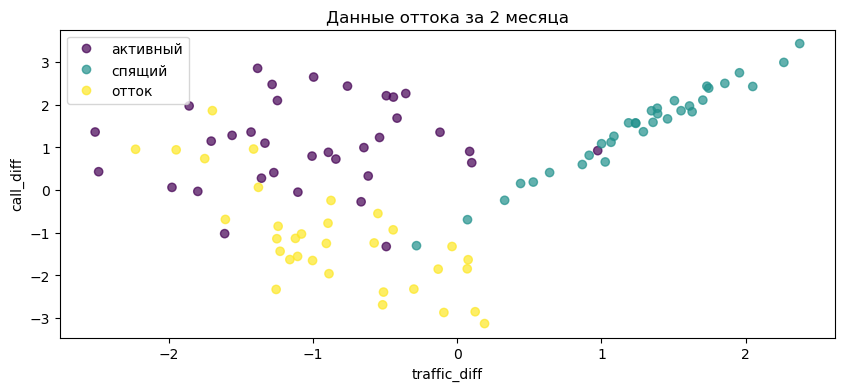

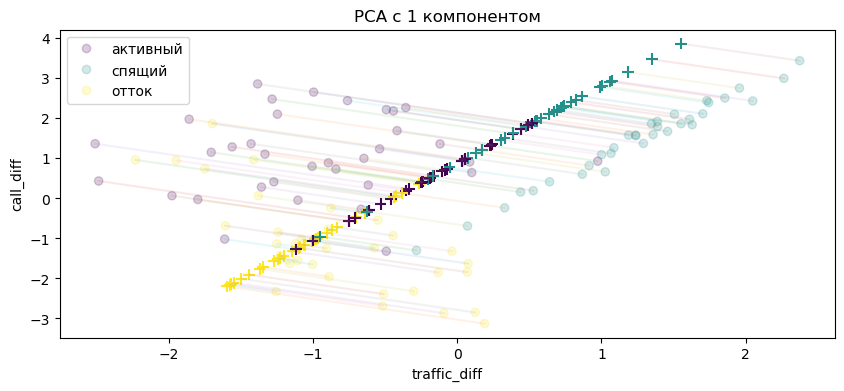

In [2]:
Y_LABELS = {0: "активный", 1: "спящий", 2: "отток"}  # Классы в легенде.

X_slice = df_source.iloc[:, [0, 2]]      # "call_diff" и "traffic_diff".
pca = PCA(n_components=1).fit(X_slice)
X_pca = pca.transform(X_slice)
X_new = pca.inverse_transform(X_pca)     # Для вывода в 2-D координатах.

for title, alpha in zip(("Данные оттока за 2 месяца", "PCA с 1 компонентом"), 
                        (.7, .2)):       # На 2-м холсте данные бледнее.
    fig, ax = plt.subplots(figsize=(10, 4))
    sc = ax.scatter(*X_slice.T.values, c=y, alpha=alpha)    
    ax.legend(handles=sc.legend_elements()[0], labels=Y_LABELS.values())
    ax.set(xlabel="traffic_diff", ylabel="call_diff")
    ax.set_title(title)
ax.scatter(*X_new.T, c=y, marker="+", s=70)    # Восстановленные из РСА.
for pair in zip(X_slice.values, X_new):
    ax.plot(*zip(*pair), alpha=.1)    # Попарные связи (проекция) точек.
plt.show()

Применить PCA к трёхмерному датасету и сжать данные до размерности $n=2$.

Для наглядности визуализировать трёхмерные данные в 3D:

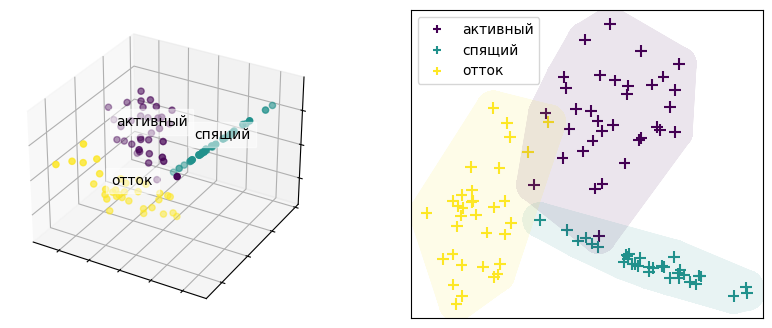

In [3]:
colors = colormaps["viridis"]         # Для подбора цвета кластера нтже.
pca = PCA(n_components=2).fit(df_source)
X_pca = pca.transform(df_source)

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
for label, name in enumerate(Y_LABELS.values()):   # Подписи класстеров.
    ax.text3D(x=X[y == label, 0].mean(), y=X[y == label, 1].mean() + 0.5,
              z=X[y == label, 2].mean(), s=name, horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
for each_ax in (ax.xaxis, ax.yaxis, ax.zaxis):
    each_ax.set_ticklabels([])          # Прячу малоинформативные шкалы.

ax = fig.add_subplot(122)
sc = ax.scatter(*X_pca.T, c=y, marker="+", s=70)
for i in Y_LABELS.keys():                # Рисую сглаженные многоугольники.
    dots = X_pca[y == i, :]           #  Координаты всех точек кластера.
    dots = dots[np.array(np.triu_indices(len(dots), 1)).T.ravel(), :]
    color = colors(i / (len(Y_LABELS.keys()) - 1))
    ax.add_patch(patches.Polygon(xy=dots, joinstyle="round", lw=25,
                                 color=color, fill=True, alpha=.1))
ax.legend(handles=sc.legend_elements()[0], labels=Y_LABELS.values())
for each_ax in (ax.xaxis, ax.yaxis):
    each_ax.set_visible(False)            # Прячу неинформативные шкалы.
plt.show()

Предлагается немного поработать с изображениями (похожий трюк можно увидеть в этой [статье на хабре](https://habr.com/ru/post/275273/)). Для этого нужно установить модуль Pillow (если у вас Анаконда, то https://anaconda.org/anaconda/pillow)

Загрузим картинку в трёхмерный numpy array и отобразим её прямо в jupyter notebook:

<class 'numpy.ndarray'> (380, 509, 3)


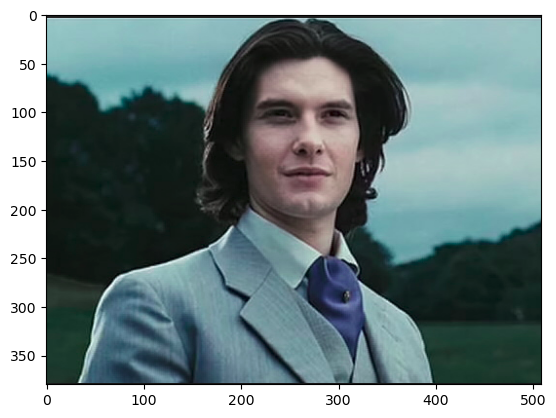

In [4]:
img = image.imread('..data/dorian_grey.png')
print(type(img),img.shape)
plt.imshow(img)
plt.show();

У нас трёхмерный массив, где третье измерение соответствует цветовой компоненте rgb. Цветную картинку можно преобразовать в двумерную серую (grayscale) с помощью формулы, найденной на [stackoverflow](https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python)

<class 'numpy.ndarray'> (380, 509)


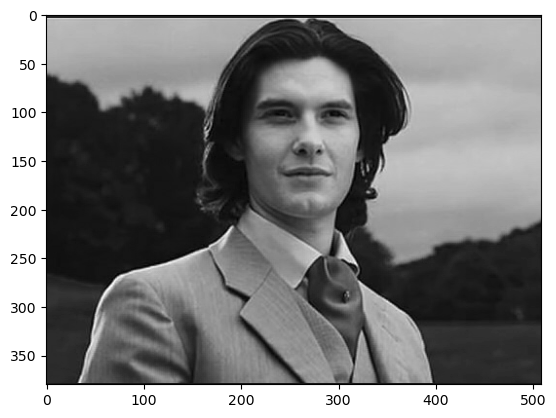

In [5]:
def rgb2gray(rgb: np.ndarray) -> np.ndarray:
    ''' Берётся среднее трёх цветов RGB'''
    tile = np.tile(np.c_[0.333, 0.333, 0.333], 
                   reps=(rgb.shape[0], rgb.shape[1],1))
    return np.sum(tile * rgb, axis=2)

img_gray = rgb2gray(img)
print(type(img_gray), img_gray.shape)
plt.imshow(img_gray, cmap = "gray")
plt.show();

# Далее

Для демонстрации сжатия данных большой размерности:
* требуется сжать массив точек изображения преобразователем TruncatedSVD c параметром n_components=5
* визуализировать массив *img_gray_svd_restored* с помощью функции *imshow*

В результате должно получиться фото в размытом виде.

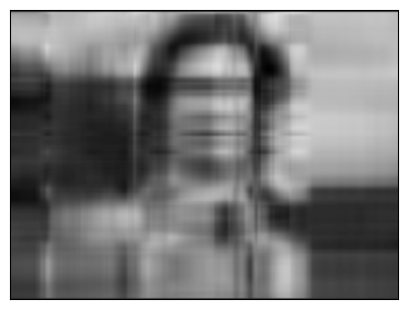

In [6]:
tsvd = TruncatedSVD(n_components=5).fit(img_gray)
img_gray_svd = tsvd.transform(img_gray)
img_gray_svd_restored = tsvd.inverse_transform(img_gray_svd)
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(img_gray_svd_restored, cmap="gray", interpolation="bicubic")
plt.show();

Мне стало интересно, как выгдядит изображение сжатое с числом главных компонент больше и меньше 5.

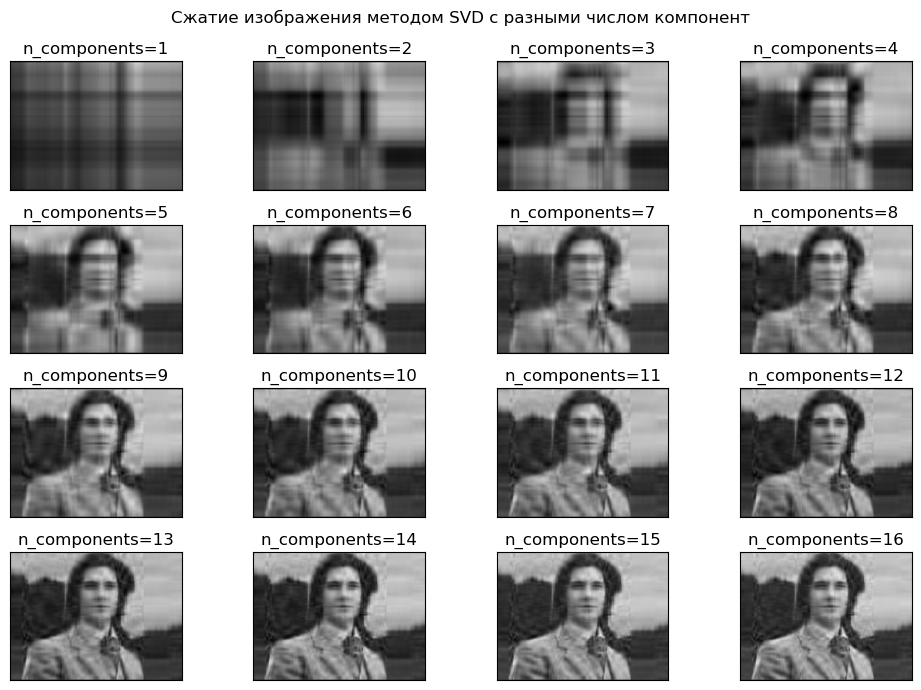

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    tsvd = TruncatedSVD(n_components=1 + i).fit(img_gray)
    img_gray_svd_restored = tsvd.inverse_transform(tsvd.transform(img_gray))
    ax.imshow(img_gray_svd_restored, cmap = "gray")
    ax.set_title(f"n_components={i + 1}")
fig.suptitle("Сжатие изображения методом SVD c разными числом компонент") 
plt.tight_layout()
plt.show()

## Как t-SNE может улучшить модели

На данных оттока client_segmentation.csv построим Baseline модель без преобразования входных данных и оценим её

In [8]:
def eval_model(input_x, input_y):
    """Обучаем и валидируем модель"""
    X_train, X_test, y_train, y_test = train_test_split(
            input_x, input_y, test_size=.3, stratify=y, random_state=42)
    clf = DecisionTreeClassifier(max_depth=2, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict_proba(X_test)
    acc_score = accuracy_score(y_test, preds.argmax(axis=1))
    print('Accuracy: %.5f' % acc_score)

df_source = pd.read_csv('client_segmentation.csv')
X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values
eval_model(X, y)

Accuracy: 0.80000


* выполните PCA преобразование матрицы  X , передайте новую матрицу в eval_model. Какое значение Accuracy получили?
* выполните t-sne преобразование матрицы  X , передайте новую матрицу в eval_model. Какое значение Accuracy получили?
* Какие выводы можно сделать?

In [9]:
for alg, name in ((PCA, "PCA"), (TSNE, "t-sne")):
    print(f"\t{name}-преобразование даёт ", end="")
    eval_model(alg().fit_transform(X), y)
print("""Выводы: снижение размерности улучшает классификацию неглубоким деревом
решений на этом наборе данных. t-sne отработал лучше PCA.
Интересно посмотреть насколько это справедливо при других random_state, 
а также с другими алгоритмами и гиперпараметрами. Код ниже:""")

	PCA-преобразование даёт Accuracy: 0.83333
	t-sne-преобразование даёт Accuracy: 0.86667
Выводы: снижение размерности улучшает классификацию неглубоким деревом
решений на этом наборе данных. t-sne отработал лучше PCA.
Интересно посмотреть насколько это справедливо при других random_state, 
а также с другими алгоритмами и гиперпараметрами. Код ниже:


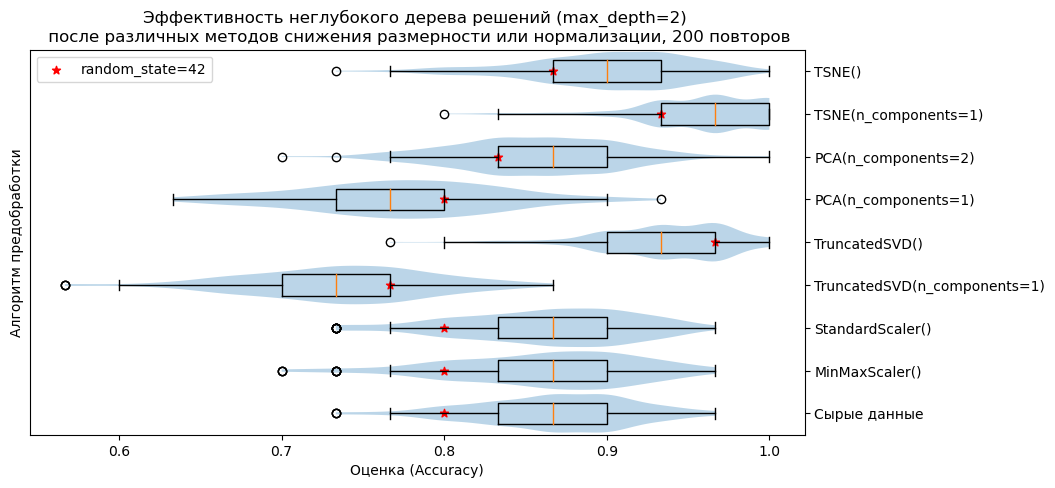

Вывод:  лучший алгоритм снижения разметности для классификации 
неглубоким деревом решений на этом наборе - t-SNE с 1 компонентом.
При random_state=42 кажется, что TruncatedSVD до 2 компонентов лучше,
но это опровергается достаточным числом итераций (200) с random_state=None.
Скалеры без изменения размерности почти на влияли на дерево решений, а
некоторые преобразователи размерности даже ухудшали accuracy.

CPU times: total: 12.7 s
Wall time: 2.95 s


In [10]:
%%time
# CPU times: total: 12.7 s   Wall time: 2.95 s
arr_t = np.typing.ArrayLike   # Пользовательские типы для аннотирования.
float_or_gen = Union[float, Generator[float, None, None]]


def castomize_eval(func: Callable[[arr_t, arr_t, int], float]
                  ) -> Callable[[arr_t, arr_t, int, int, Optional[object]],
                                float_or_gen]:
    """Декорирует валидатор оберткой с параметрами"""
    
    def wrapper(X: arr_t, y: arr_t, random_state: int = 42, n_iter: int = 200,
                preproc: Optional[object] = None) -> float_or_gen:
        """Оборачивает функцию циклом с предобработкой данных"""
        X_prep = preproc.fit_transform(X) if preproc else X.copy()
        if random_state:
            score = func(input_x=X_prep, input_y=y, random_state=random_state)
            return score
        return (func(X_prep, y, random_state=None) for _ in range(n_iter))
    
    return wrapper

@castomize_eval
def eval_model(input_x: arr_t, input_y: arr_t, random_state: int =42) -> float:
    """Обучает и валидирует модель. Возвращает оценку (не печатает)."""
    X_train, X_test, y_train, y_test = train_test_split(
        input_x, input_y, test_size=.3, stratify=y, random_state=random_state)
    clf = DecisionTreeClassifier(max_depth=2, random_state=random_state)
    clf.fit(X_train, y_train)
    preds = clf.predict_proba(X_test)
    return accuracy_score(y_test, preds.argmax(axis=1))


PREPROCESSORS = [None, MinMaxScaler(), StandardScaler(), TruncatedSVD(1),
                 TruncatedSVD(2), PCA(1), PCA(2), TSNE(1), TSNE(2)]

mtx = [eval_model(X, y, random_state=None, preproc=pr) for pr in PREPROCESSORS]
mtx42 = [eval_model(X, y, random_state=42, preproc=pr) for pr in PREPROCESSORS]
data = pd.DataFrame(data=mtx, index=PREPROCESSORS).T

fig, ax = plt.subplots(figsize=(10, 5))
ax.violinplot(data, vert=False, widths=.9, showextrema=False)
ax.boxplot(data.values, vert=False)
y_ticks = range(1, 1 + data.shape[1])
ax.scatter(mtx42, y_ticks, c="r", marker="*", label="random_state=42")
ax.set_yticks(ticks=y_ticks, labels=["Сырые данные"] + PREPROCESSORS[1:])
ax.yaxis.tick_right()
ax.set(title="Эффективность неглубокого дерева решений (max_depth=2) \n после "
       "различных методов снижения размерности или нормализации, 200 повторов",
       xlabel="Оценка (Accuracy)", ylabel="Алгоритм предобработки")
ax.legend(loc="upper left")
plt.show();
print("""Вывод:  лучший алгоритм снижения разметности для классификации 
неглубоким деревом решений на этом наборе - t-SNE с 1 компонентом.
При random_state=42 кажется, что TruncatedSVD до 2 компонентов лучше,
но это опровергается достаточным числом итераций (200) с random_state=None.
Скалеры без изменения размерности почти на влияли на дерево решений, а
некоторые преобразователи размерности даже ухудшали accuracy.\n""")